# TitanicSexism (fairness in ML)

*Women and children first?! We'll never get that past the regulators!*

## Fairness in machine learning
There's a growing awareness in machine learning of the problems that can be caused by unfair models, and the difficulty involved in creating fair models from biased data. Even when legally protected characteristics like sex, age, and race aren't explicitly used, other features can act as proxies and subtly leak bias. Understanding and dealing sources of bias and their interactions in models is currently an unsolved problem, but tools are becoming more readily available to approach it

Existing approaches for bias mitigation can be applied at different stage in ML pipelines - in pre-processing, during model training, and after prediction. This kernel will demonstrate applying [reweighing](http://doi.org/10.1007/s10115-011-0463-8), a relatively simple pre-processing technique that learns weights for training data that can be used during training to reduce bias.

Clearly Titanic models typically rely too heavily on sex as a feature, which is unacceptable in our modern and enlightened world. To try and address this problem we'll;
 - Assess the bias in the Titainc dataset
 - Apply reweighing in pre-processing using the new [IBM AIF 360 toolbox](https://github.com/IBM/AIF360)
 - Train benchmark and "fair" models, using both linear (logistic regression) and non-parametric (random forest) models
 - Compare the performance of the models
 - Try different techniques for comparing the fairness of the benchmark and "fair" models, and compare the effectiveness of the reweighing approach between logistic regression and random forest.

In [1]:
# We're going to use type hinting
from typing import List, Union, Dict

# Modelling. Warnings will be used to silence various model warnings for tidier output
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning
import warnings

# Data handling/display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import auc, roc_auc_score, roc_curve

# IBM's fairness tooolbox:
from aif360.datasets import BinaryLabelDataset  # To handle the data
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric  # For calculating metrics
from aif360.explainers import MetricTextExplainer  # For explaining metrics
from aif360.algorithms.preprocessing import Reweighing  # Preprocessing technique

sns.set()
sns.set_context("talk")

In [2]:
# Load data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
test.loc[:, 'Survived'] = 0 

# Preprocessing

Reweighing requires processed numerical data, so we need to pre-process the raw Titanic data before trying to apply it.

We'll use a sklearn pipeline to do pre-processing of the data. For those not familiar with sklearn pipelines, they can be used to chain processing, feature engineering and model steps together. This allows for hyperparameters search over for the full pipeline, rather than just the model. They work with sklearn's object orientated fit/transform/predict paradigm.

We're not going to use them to their full potential here, but will create custom transformers and a pipeline to do just the initial pre-processing. The transformers will each define .fit() and .transform() methods; .fit() will be used to learn from the training data, and .transform() will be applied to the training and test data.

There will be two forks to the pipeline, one to handle object/string features, and the other to handle numeric features. The outputs of these will be combined to create the features for modelling

The following cells define classes we need. For convenience, these will work with DataFrames.


In [3]:
# Preprocessing will be done using a sklearn pipeline. We need these bits to make the transformers and connect them.
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

# For the logistic regression model
from sklearn.preprocessing import StandardScaler

## SelectCols
This is a helper class. It simply holds a list of column names, which it will return when it finds them in a DataFrame passed to .transform is called (each transformer in a Pipeline calls .fit_transform() in turn).

In [4]:
class SelectCols(TransformerMixin):
    """Select columns from a DataFrame."""
    def __init__(self, cols: List[str]) -> None:
        self.cols = cols

    def fit(self, x: None) -> "SelectCols":
        """Nothing to do."""
        return self

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        """Return just selected columns."""
        return x[self.cols]    

### Example output

In [5]:
sc = SelectCols(cols=['Sex', 'Survived'])
sc.transform(train.sample(5))

,Sex,Survived
298,male,1
793,male,0
551,male,0
172,female,1
64,male,0


## LabelEncoder

To deal with the object/string columns. Does simple label encoding and handles unseen data (ie. categorical levels seen in .transform() that weren't previously seen in .fit()).

In [6]:
class LabelEncoder(TransformerMixin):
    """Convert non-numeric columns to numeric using label encoding. 
    Handles unseen data on transform."""
    def fit(self, x: pd.DataFrame) -> "LabelEncoder":
        """Learn encoder for each column."""
        encoders = {}
        for c in x:
            # Make encoder using pd.factorize on unique values, 
            # then convert to a dictionary
            v, k = zip(pd.factorize(x[c].unique()))
            encoders[c] = dict(zip(k[0], v[0]))

        self.encoders_ = encoders

        return self

    def transform(self, x) -> pd.DataFrame:
        """For columns in x that have learned encoders, apply encoding."""
        x = x.copy()
        for c in x:
            # Ignore new, unseen values
            x.loc[~x[c].isin(self.encoders_[c]), c] = np.nan
            # Map learned labels
            x.loc[:, c] = x[c].map(self.encoders_[c])

        # Return without nans
        return x.fillna(-2).astype(int)

### Example output

In [7]:
le = LabelEncoder()
le.fit_transform(train[['Pclass', 'Sex']].sample(5))

,Pclass,Sex
91,0,0
272,1,1
4,0,0
593,0,1
657,0,1


In [8]:
le.encoders_

{'Pclass': {3: 0, 2: 1}, 'Sex': {'male': 0, 'female': 1}}

In [9]:
class NumericEncoder(TransformerMixin):
    """Remove invalid values from numerical columns, replace with median."""
    def fit(self, x: pd.DataFrame) -> "NumericEncoder":
        """Learn median for every column in x."""
        # Find median for all columns, handling non-NaNs invalid values and NaNs
        # Where all values are NaNs (after coercion) the median value will be a NaN.
        self.encoders_ = {
            c: pd.to_numeric(x[c],
                             errors='coerce').median(skipna=True) for c in x}

        return self

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        """For each column in x, encode NaN values are learned 
        median and add a flag column indicating where these 
        replacements were made"""

        # Create a list of new DataFrames, each with 2 columns
        output_dfs = []
        for c in x:
            new_cols = pd.DataFrame()
            # Find invalid values that aren't nans (-inf, inf, string)
            invalid_idx = pd.to_numeric(x[c].replace([-np.inf, np.inf],
                                                     np.nan),
                                        errors='coerce').isnull()

            # Copy to new df for this column
            new_cols.loc[:, c] = x[c].copy()
            # Replace the invalid values with learned median
            new_cols.loc[invalid_idx, c] = self.encoders_[c]
            # Mark these replacement in a new column called 
            # "[column_name]_invalid_flag"
            new_cols.loc[:, f"{c}_invalid_flag"] = invalid_idx.astype(np.int8)

            output_dfs.append(new_cols)

        # Concat list of output_dfs to single df
        df = pd.concat(output_dfs,
                       axis=1)

        # Return wtih an remaining NaNs removed. These might exist if the median
        # is a NaN because there was no numeric data in the column at all.
        return df.fillna(0)

### Example output

In [10]:
ne = NumericEncoder()
ne.fit_transform(train[['Age', 'Fare']].sample(5))

,Age,Age_invalid_flag,Fare,Fare_invalid_flag
791,16.0,0,26.0000,0
728,25.0,0,26.0000,0
302,19.0,0,0.0000,0
535,7.0,0,26.2500,0
332,38.0,0,153.4625,0


In [11]:
ne.encoders_

{'Age': 19.0, 'Fare': 26.0}

## Constructing the pipeline

The two forks are joined as individual pipelines, then their output is concatenated using a feature union.

In [12]:
## Constructing the pipeline

# LabelEncoding fork: Select object columns -> label encode
pp_object_cols = Pipeline([('select', SelectCols(cols=['Sex', 'Survived', 
                                                       'Cabin', 'Ticket', 
                                                       'SibSp', 'Embarked',
                                                       'Parch', 'Pclass',
                                                       'Name'])),
                           ('process', LabelEncoder())])

# NumericEncoding fork: Select numeric columns -> numeric encode
pp_numeric_cols = Pipeline([('select', SelectCols(cols=['Age', 
                                                        'Fare'])),
                            ('process', NumericEncoder())])


# We won't use the next part, but typically the pipeline would continue to 
# the model (after dropping 'Survived' from the training data, of course). 
# For example:
pp_pipeline = FeatureUnion([('object_cols', pp_object_cols),
                            ('numeric_cols', pp_numeric_cols)])

model_pipeline = Pipeline([('pp', pp_pipeline),
                           ('mod', LogisticRegression())])
# This could be run with model.pipeline.fit_predict(x), and passed to a 
# gridsearch object 

## Running the pipeline

pp_pipeline.fit_transform() can called on the training set, however for the sake of sticking with DataFrames, we'll avoid calling the FeatureUnion and do it like this instead. 

In [13]:
train_, valid = train_test_split(train,
                                 test_size=0.3)

# .fit_transform on train
train_pp = pd.concat((pp_numeric_cols.fit_transform(train_), 
                      pp_object_cols.fit_transform(train_)),
                     axis=1)

# .transform on valid
valid_pp = pd.concat((pp_numeric_cols.transform(valid), 
                      pp_object_cols.transform(valid)),
                     axis=1)
valid_pp.sample(5)

,Age,Age_invalid_flag,Fare,Fare_invalid_flag,Sex,Survived,Cabin,Ticket,SibSp,Embarked,Parch,Pclass,Name
380,42.0,0,227.5250,0,1,1,-2,424,1,1,1,2,-2
183,1.0,0,39.0000,0,0,1,73,326,3,0,2,1,-2
254,41.0,0,20.2125,0,1,0,-2,-2,1,0,0,0,-2
482,50.0,0,8.0500,0,0,0,-2,-2,1,0,1,0,-2
670,40.0,0,39.0000,0,1,1,-2,258,2,0,2,1,-2


In [14]:
# .transform on test
test_pp = pd.concat((pp_numeric_cols.transform(test), 
                     pp_object_cols.transform(test)),
                    axis=1)
test_pp.sample(5)

,Age,Age_invalid_flag,Fare,Fare_invalid_flag,Sex,Survived,Cabin,Ticket,SibSp,Embarked,Parch,Pclass,Name
389,6.0,0,21.0750,0,0,0,-2,80,5,0,2,0,-2
185,40.0,0,16.0000,0,0,0,-2,-2,1,0,1,1,-2
130,32.0,0,8.0500,0,0,0,-2,-2,1,0,1,0,-2
109,18.5,0,13.0000,0,0,0,-2,-2,1,0,1,1,-2
156,29.0,0,221.7792,0,1,0,-2,86,1,0,1,2,-2


# Benchmark models

## Prepare the data
Split the features and targets, and create a training and validation set.

In [15]:
target = 'Survived'
x_columns = [c for c in train_pp if c != target]
x_train, y_train = train_pp[x_columns], train_pp[target]
x_valid, y_valid = valid_pp[x_columns], valid_pp[target]
x_test = test_pp[x_columns]

## Train models

Train LogisticRegression and a RandomForestClassifier. Also dump out the test predictions to see how to do on the leaderboard.

warnings is just used here to shut up some FutureWarnings.

In [16]:
sub = pd.read_csv('../input/gender_submission.csv')

In [17]:
biased_lr = LogisticRegression()

with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

    biased_lr.fit(x_train, y_train)
    
print(f"Logistic regression validation accuracy: {biased_lr.score(x_valid, y_valid)}")

sub.loc[:, 'Survived'] = biased_lr.predict(x_test).astype(int)
sub.to_csv('biased_lr.csv', 
           index=False)

Logistic regression validation accuracy: 0.7873134328358209


In [18]:
biased_rfc = RandomForestClassifier(n_estimators=100, 
                                    max_depth=4)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    
    biased_rfc.fit(x_train, y_train)
    
print(f"Random forest validation accuracy: {biased_rfc.score(x_valid, y_valid)}")

sub.loc[:, 'Survived'] = biased_rfc.predict(x_test).astype(int)
sub.to_csv('biased_rfc.csv', 
           index=False)

Random forest validation accuracy: 0.8208955223880597


# "Fair" models

Before applying any fairness processing or calculating metrics, we need to set up a  BinaryLabelDataset object (which is part of AIF360) to hold the data. Then we'll specify sex as a protected characteristic, and men (label: 1) as the underprivileged group.

In [19]:
train_pp_bld = BinaryLabelDataset(df=pd.concat((x_train, y_train),
                                               axis=1),
                                  label_names=['Survived'],
                                  protected_attribute_names=['Sex'],
                                  favorable_label=1,
                                  unfavorable_label=0)

privileged_groups = [{'Sex': 1}]
unprivileged_groups = [{'Sex': 0}]

## Metrics

AIF comes with a metrics and an explainer class that runs relevant metrics different types of datasets. Here we'll add a method to explain everything relevant to our banary problem with a single call to .explain().

In [20]:
class MetricAdditions:
    def explain(self,
                disp: bool=True) -> Union[None, str]:
        """Explain everything available for the given metric."""

        # Find intersecting methods/attributes between MetricTextExplainer and provided metric.
        inter = set(dir(self)).intersection(set(dir(self.metric)))

        # Ignore private and dunder methods
        metric_methods = [getattr(self, c) for c in inter if c.startswith('_') < 1]

        # Call methods, join to new lines
        s = "\n".join([f() for f in metric_methods if callable(f)])

        if disp:
            print(s)
        else:
            return s
        
        
class MetricTextExplainer_(MetricTextExplainer, MetricAdditions):
    """Combine explainer and .explain."""
    pass

In [21]:
# Create the metric object
metric_train_bld = BinaryLabelDatasetMetric(train_pp_bld,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

# Create the explainer object
explainer = MetricTextExplainer_(metric_train_bld)
# Explain relevant metrics
explainer.explain()

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.5511737089201878
Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.5511737089201878
Number of positive-outcome instances: 242.0
Number of instances: 623.0
Number of negative-outcome instances: 381.0
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.26625000000000004
Consistency (Zemel, et al. 2013): [0.67800963]


We'll consider statistical mean difference here as it has a simple interpretation. It's the difference in mean outcomes when the data is split by the un/privileged groups we defined. If it's not 0, one group has better outcomes that the other - in this case men are more likely to have an unfavourable outcome.

## Reweighing

Reweighing won't change the training data at all, rather it will learn new weights for each training row that will make the mean difference in outcomes between the specified groups 0.

Specifically here:
  - Examples of men who don't survive will be downweighted
  - Examples men who survive will be upweighted
  - Examples of women who survive will be downweighted
  - Examples of women who die will be upweighted
  
Practically, reweighing works like an sklearn transformer (on the BinaryLabelDataset)


In [22]:
rw = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
train_pp_bld_f = rw.fit_transform(train_pp_bld)

The new weights are stored in .instance_weights, for example:

In [23]:
pd.DataFrame({'Sex': x_train.Sex,
              'Survived': y_train,
              'Original_weight': np.ones(shape=(x_train.shape[0],)),
              'new_weight': train_pp_bld_f.instance_weights}).sample(15)

,Sex,Survived,Original_weight,new_weight
586,0,0,1.0,0.764446
379,0,0,1.0,0.764446
609,1,1,1.0,0.517115
17,0,1,1.0,1.942215
548,0,0,1.0,0.764446
618,1,1,1.0,0.517115
124,0,0,1.0,0.764446
53,1,1,1.0,0.517115
583,0,0,1.0,0.764446
773,0,0,1.0,0.764446


## Model training

The new weights are passed to the classifier for training along with the unmodified data. Because the training data is unmodified, we don't need to do anything to the test set when making predictions.



In [24]:
unbiased_lr = LogisticRegression()
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
        
    unbiased_lr.fit(x_train, y_train,
                    sample_weight=train_pp_bld_f.instance_weights)
    
print(f"Logistic regression validation accuracy: {unbiased_lr.score(x_valid, y_valid)}")

sub.loc[:, 'Survived'] = unbiased_lr.predict(x_test).astype(int)
sub.to_csv('unbiased_lr.csv', 
           index=False)

Logistic regression validation accuracy: 0.6940298507462687


In [25]:
unbiased_rfc = RandomForestClassifier(n_estimators=100,
                                      max_depth=4)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    
    unbiased_rfc.fit(x_train, y_train,
                     sample_weight=train_pp_bld_f.instance_weights)
    
print(f"Random forest validation accuracy: {unbiased_rfc.score(x_valid, y_valid)}")

sub.loc[:, 'Survived'] = unbiased_rfc.predict(x_test).astype(int)
sub.to_csv('unbiased_rfc.csv', 
           index=False)

Random forest validation accuracy: 0.6604477611940298


# Did it work?

Based on the validation set it looks like we've lost some performance by trying to remove the effectiveness of the Sex feature (is anyone surprised?). 


Accuracy:


,LogReg,RFC
Unfair,0.787313,0.820896
Fair,0.694030,0.660448


AUC:


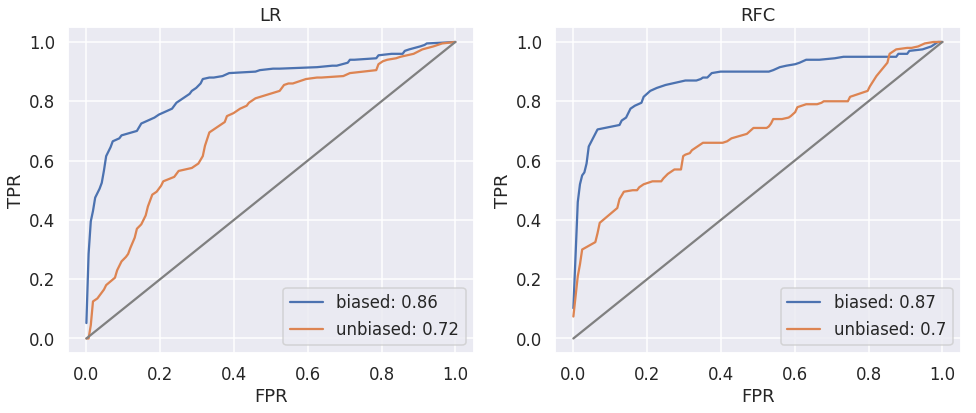

In [26]:
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray],
             title: str='', 
             ax=None) -> None:
    
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, 
                          y=tpr,
                          ci=None,
                          ax=ax
                         )
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
    
    ax.legend(leg)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    sns.lineplot(x=[0, 1],
                 y=[0, 1],
                 color='gray',
                 ax=ax)
    
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [biased_lr.score(x_valid, y_valid), 
                                 unbiased_lr.score(x_valid, y_valid)],
                      'RFC': [biased_rfc.score(x_valid, y_valid),
                              unbiased_rfc.score(x_valid, y_valid)]}, 
                     index =['Unfair', 'Fair']))

print('AUC:')
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
plot_auc(y_valid, 
         {'biased': biased_lr.predict_proba(x_valid)[:, 1],
          'unbiased': unbiased_lr.predict_proba(x_valid)[:, 1]},
         title='LR',
         ax=ax[0]) 
plot_auc(y_valid, 
         {'biased': biased_rfc.predict_proba(x_valid)[:, 1],
          'unbiased': unbiased_rfc.predict_proba(x_valid)[:, 1]},
         title='RFC',
         ax=ax[1]) 
plt.show()

But have we really created a fairer model? This is a harder question to answer.

## Feature importance

The most superficial way to try and figure out what the clasifier is thinking is to plot the feature importance.

In [27]:
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier],
                       names: List[str],
                       scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names,
                         'importance': imp,
                         'std': var}).sort_values('importance',
                                                  ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

### "Unfair" models

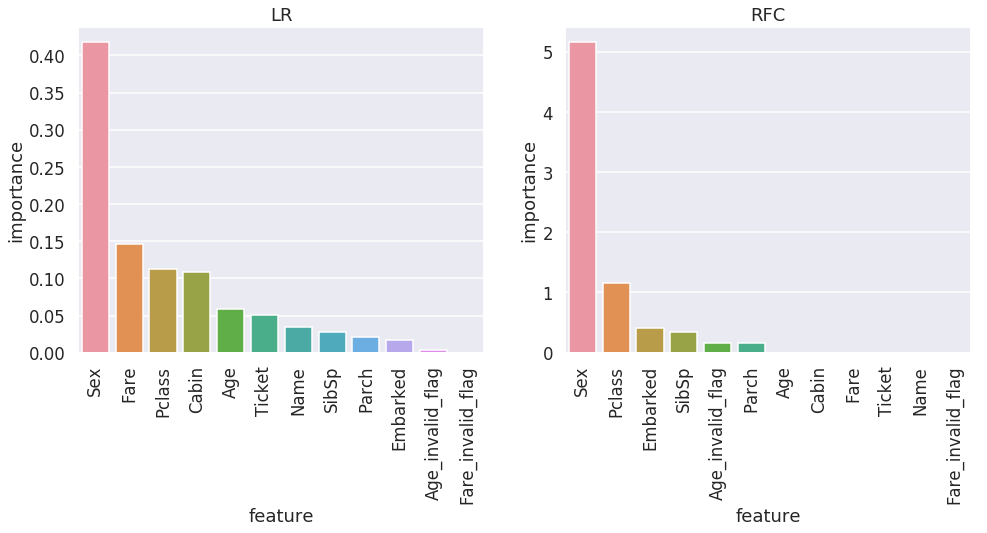

In [28]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))

plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(biased_lr,
                                                names=x_train.columns.tolist(),
                                                scale=x_train.std()),
                       ax=ax[1])
_ = ax[0].set_title('LR')
plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(biased_rfc,
                                                names=x_train.columns.tolist()),
                       ax=ax[0])
_ = ax[1].set_title('RFC')

### "Fair" models

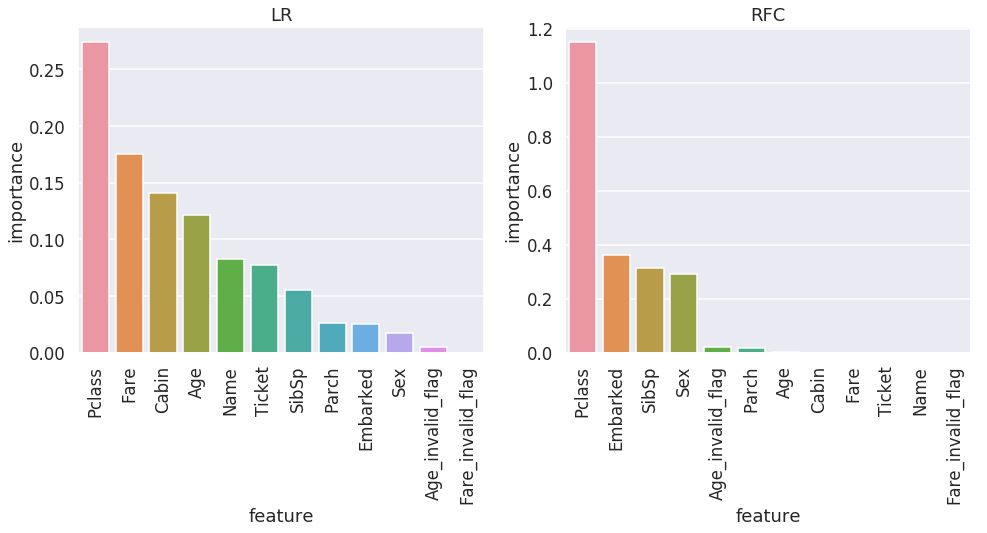

In [29]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))

plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(unbiased_lr,
                                                names=x_train.columns.tolist(),
                                                scale=x_train.std()),
                       ax=ax[1])
_ = ax[0].set_title('LR')
plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(unbiased_rfc,
                                                names=x_train.columns.tolist()),
                       ax=ax[0])
_ = ax[1].set_title('RFC')

Sex is certainly a less important feature in both models, but hasn't completely eliminated.

# Fairness metrics
Model accuracy depends on the classification threshold applied to the predicted probabilities. Similarly, fairness varies with this threshold; members of the same groups may can similar predication probabilities, assuming the group is predictive, so can be separated by the selected threshold.

The following code will calculate the balanced accuracy of the model at several threshold steps. Disparate impact and average odds difference are also calculated as measures of fairness (see also: https://github.com/IBM/AIF360/blob/master/examples/demo_reweighing_preproc.ipynb).

**Balanced accuracy** (accuracy balanced for target proportion) = (TP / P + TN / N) / 2  
**Average odds difference** - closer to 0 is better    
**Disparate impact** - closer to 0.5 is better

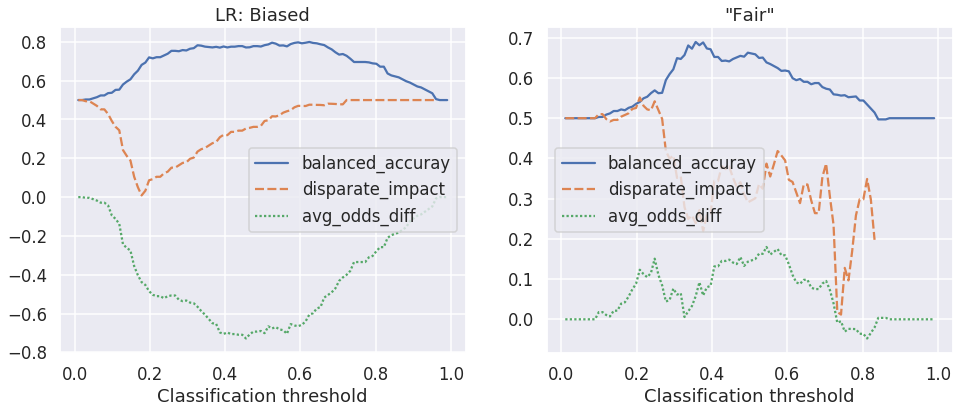

In [30]:
def calc_metrics(mod, x: pd.DataFrame, y_true: pd.DataFrame) -> pd.DataFrame:
    """Calculate fairness metrics at each model threshold."""
    
    # Create a BinaryLabelDataset (as before training)
    bld = BinaryLabelDataset(df=pd.concat((x, y_true),
                                               axis=1),
                                  label_names=['Survived'],
                                  protected_attribute_names=['Sex'],
                                  favorable_label=1,
                                  unfavorable_label=0)

    privileged_groups = [{'Sex': 1}]
    unprivileged_groups = [{'Sex': 0}]
    
    # Create a second set to hold the predicted labels
    bld_preds = bld.copy(deepcopy=True)
    preds = mod.predict_proba(x)[:, 1]

    balanced_accuracy = []
    disp_impact = []
    avg_odd_diff = []
    
    # For threshold values between 0 and 1:
    thresh = np.linspace(0.01, 0.99, 100)
    for t in thresh:
        
        # Apply threshold and set labels in bld for predictions
        bld_preds.labels[preds > t] = 1
        bld_preds.labels[preds <= t] = 0

        # Calculate the metrics for this threshold
        valid_metric = ClassificationMetric(bld, bld_preds, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

        # Save the balanced accuracy of the model, and the metrics
        balanced_accuracy.append(0.5 * (valid_metric.true_positive_rate()
                                        + valid_metric.true_negative_rate()))
        avg_odd_diff.append(valid_metric.average_odds_difference())
        disp_impact.append(np.abs(valid_metric.disparate_impact() - 0.5))

    # Return as df indexed by threshold
    metrics = pd.DataFrame({'balanced_accuray': balanced_accuracy,
                            'disparate_impact': disp_impact,
                            'avg_odds_diff': avg_odd_diff},
                          index=thresh)
    return metrics


def plot_metrics(metrics: pd.DataFrame, 
                 title: str='', **kwargs) -> None:
    """Plot the metrics df from calc_metrics with seaborn."""
    ax = sns.lineplot(data=metrics, 
                      **kwargs)
    ax.set_title(title)
    ax.set_xlabel('Classification threshold')

# Plot for LR
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(biased_lr, x_valid, y_valid),
                ax=ax[0],
                title="LR: Biased")
    
    plot_metrics(calc_metrics(unbiased_lr, x_valid, y_valid),
                ax=ax[1],
                title='"Fair"')

For the LogisticRegression model, the biased model is very unfair at the optimal balanced accuracy threhold around 0.5. Disparte impact and average odds diference both indicate bais in the predictions.Notice that at prediction thesholds of 0 and 1, where everyone is treated the same, the metrics indicate no bias. Balanced accuracy is 50% in these cases as it corrects for the samping bias (between survived and no survived).

For the "fair" model avg odds appears reasonable, and disparat impact indicates less bias at the optimal classification threshold around 0.4 indicated

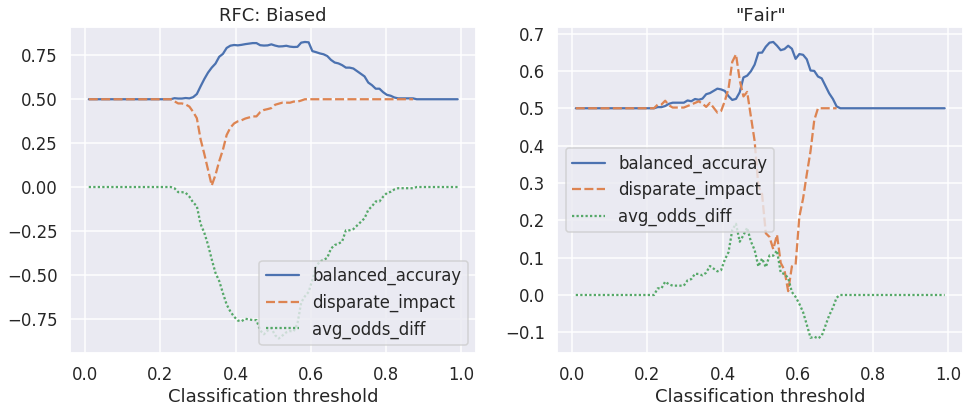

In [31]:
# Plot for RFC
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(biased_rfc, x_valid, y_valid),
                ax=ax[0],
                title="RFC: Biased")
    
    plot_metrics(calc_metrics(unbiased_rfc, x_valid, y_valid),
                ax=ax[1],
                title='"Fair"')

There are similar results for the random forest although disparate impact looks a bit worse in the fair model (note this may vary between notebook runs - the validation set here is only 223 rows!)

# Conclusions (WIP)
  - There's no free lunch (or hunch) here, attempting to remove sex as a predictor harms model performance (try submitting the output files to compare against the test set). This isn't a particularly suprising finding given that, for the Titianic dataset, gender alone produces a pretty good model.
  - Less bias is removed from the random forest model, due to interactions with other features. For example, if a certain age range contains only women who surive then a tree split can be created on age that acts as a proxy for sex. Reweighing be more effective for linear models because this is avoided.
  
# Next steps
  - Other techniques?